![](../src/image/meli5.JPG)

# Generador Embeddings Text-Embedding-3-Small

#### En este punto usare  el text-embedding-3-small para la generacion de los embeddings.

### Pasos
1. [Preparacion de la data.](#1)
1. [Preprocesamiento de los datos.](#2)
1. [Generacion de Embedding](#3)
1. [Extraccion de Embedding](#4)



<a id="1"></a> <br>
## 1.Preparacion de la data

#### El dataset usado es el proporcionado en el ejercicio ya con las etiquetas obtenidas en la clusterizacion. El dataset posee 185250 registros los cuales 117094 poseen etiquetas. Esta data mantiene la informacion de sellers de un e-commerce. de los cuales tomaremos 50 registros de cada cluster, 10 de los que no tienen etiqueta para la prediccion.

#### Combinaran las variables, y con el modelo se codificara las variables combinadas y dara resultado un vector embedding

In [2]:
import pandas as pd
import tiktoken
import matplotlib.pyplot as plt
import numpy as np

#openai
from openai import OpenAI
from utils.embeddings_utils import get_embedding

In [ ]:
embedding_model = "text-embedding-3-small"
embedding_encoding = "cl100k_base"
max_tokens = 8000  

In [ ]:
path = 'D:\Clustering_MeLi\src\data\processed\data_embedding_v1.csv'
df = pd.read_csv(path)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185250 entries, 0 to 185249
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         185250 non-null  int64  
 1   tim_day            185250 non-null  object 
 2   seller_nickname    185250 non-null  object 
 3   titulo             185250 non-null  object 
 4   seller_reputation  182878 non-null  object 
 5   stock              185250 non-null  int64  
 6   logistic_type      185250 non-null  object 
 7   condition          185250 non-null  object 
 8   is_refurbished     185250 non-null  bool   
 9   price              183734 non-null  float64
 10  regular_price      49956 non-null   float64
 11  categoria          185250 non-null  object 
 12  url                185250 non-null  object 
 13  category_id        185250 non-null  object 
 14  category_name      185250 non-null  object 
 15  Kmeans             117094 non-null  float64
 16  Ag

In [ ]:
siglas = ['XD', 'FBM', 'DS', 'FLEX', 'Otro']
logistic_type = ['Cross Docking', 'FulfilledbyMerchant', 'DropShipping', 'FLEX', 'Otro']

df_lgt = pd.DataFrame(data={'Siglas_lt':siglas,"Lt":logistic_type})
df=pd.merge(left=df, right=df_lgt, how='left', left_on='logistic_type',right_on='Siglas_lt')
df.head(2)

Clusters = ['0', '1', '2', '3', '4']
Clusters_Def = ['Sellers Estables', 'Sellers con catalogos', 'Sellers Medianos', 'Sellers Mayoristas', 'Sellers Premiuns']

df_cluster = pd.DataFrame(data={'Clusters':Clusters,"Cluster_Def":Clusters_Def})



In [ ]:
df.columns

Index(['Unnamed: 0', 'tim_day', 'seller_nickname', 'titulo',
       'seller_reputation', 'stock', 'logistic_type', 'condition',
       'is_refurbished', 'price', 'regular_price', 'categoria', 'url',
       'category_id', 'category_name', 'Kmeans', 'AgC', 'products',
       'Siglas_lt', 'Lt'],
      dtype='object')

In [ ]:
df['stock']=df['stock'].astype(str)
df['price']=df['price'].astype(str)
df['stock']=df['stock'].astype(str)
df['is_refurbished']=df['is_refurbished'].astype(int)
df['is_refurbished']=df['is_refurbished'].astype(str)
df.drop('Unnamed: 0',axis=1,inplace=True)

In [ ]:
df=df[df['seller_reputation'].isnull()==False]
df.shape

(182878, 19)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 182878 entries, 0 to 185249
Data columns (total 19 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   tim_day            182878 non-null  object 
 1   seller_nickname    182878 non-null  object 
 2   titulo             182878 non-null  object 
 3   seller_reputation  182878 non-null  object 
 4   stock              182878 non-null  object 
 5   logistic_type      182878 non-null  object 
 6   condition          182878 non-null  object 
 7   is_refurbished     182878 non-null  object 
 8   price              182878 non-null  object 
 9   regular_price      49956 non-null   float64
 10  categoria          182878 non-null  object 
 11  url                182878 non-null  object 
 12  category_id        182878 non-null  object 
 13  category_name      182878 non-null  object 
 14  Kmeans             117094 non-null  float64
 15  AgC                117094 non-null  float64
 16  product

In [ ]:
df['mix'] = "Stock: " + df['stock'].str.strip() + "; Refurbished: " + df['is_refurbished'].str.strip() + "; Logistic: " + df['Lt'].str.strip()+ "; Condition: " + df.condition.str.strip() + "; Price: " + df.price.str.strip() + "; Categoria " + df['category_id'].str.strip()
print(df.shape)


df.head(2)

(182878, 20)


,tim_day,seller_nickname,titulo,seller_reputation,stock,logistic_type,condition,is_refurbished,price,regular_price,categoria,url,category_id,category_name,Kmeans,AgC,products,Siglas_lt,Lt,mix
0,2024-08-01,5a39342818,Gel Cerave Limpiador Espumoso Piel Normal A Gr...,green_platinum,16155,FBM,new,0,260.93,355.0,BEAUTY PERSONAL CARE,https://articulo.mercadolibre.com.mx/MLM-17883...,BEAUTY PERSONAL CARE,CUIDADO PERSONAL Y BELLEZA,NaN,NaN,NaN,FBM,FulfilledbyMerchant,Stock: 16155; Refurbished: 0; Logistic: Fulfil...
1,2024-08-01,5a39342818,Kit Garnier Express Aclara Serum +crema +gel C...,green_platinum,6253,FBM,new,0,344.26,NaN,BEAUTY PERSONAL CARE,https://articulo.mercadolibre.com.mx/MLM-31259...,BEAUTY PERSONAL CARE,CUIDADO PERSONAL Y BELLEZA,NaN,NaN,NaN,FBM,FulfilledbyMerchant,Stock: 6253; Refurbished: 0; Logistic: Fulfill...


#### Como mencione anteriormente seleccionaremos 50 de cada cluster para tener una data de 210 registros, donde 10 son de validacion.

In [ ]:
df.columns

Index(['tim_day', 'seller_nickname', 'titulo', 'seller_reputation', 'stock',
       'logistic_type', 'condition', 'is_refurbished', 'price',
       'regular_price', 'categoria', 'url', 'category_id', 'category_name',
       'Kmeans', 'AgC', 'products', 'Siglas_lt', 'Lt', 'mix'],
      dtype='object')

In [ ]:
col = ['tim_day', 'seller_nickname', 'titulo', 'seller_reputation', 'stock',
       'logistic_type', 'condition', 'is_refurbished', 'price',
       'regular_price', 'categoria', 'url', 'category_id', 'category_name',
        'Kmeans', 'AgC', 'products','Siglas_lt', 'Lt', 'mix']
cntxcluster = 50
clusters=4
dfy=pd.DataFrame()
for i in range(0,clusters): # Sacamos los 50 registros de cada cluster.
    print(f"Cluster {i}")
    reviews = df[df.Kmeans == i].sample(cntxcluster, random_state=42).values
    dfx = pd.DataFrame(data=reviews,columns=col)
    dfy = pd.concat([dfy,dfx], axis=0)



print(dfy.shape)
print(dfy.Kmeans.value_counts())
dfy = pd.concat([dfy,df[df['Kmeans'].isnull()][:10]], axis=0) # concatenamos con los vacios
print(dfy.shape)
dfy = dfy.iloc[np.random.permutation(len(dfy))].reset_index(drop=True)
dfy.head(2)

Cluster 0
Cluster 1
Cluster 2
Cluster 3
(200, 20)
Kmeans
0.0    50
1.0    50
2.0    50
3.0    50
Name: count, dtype: int64
(210, 20)


,tim_day,seller_nickname,titulo,seller_reputation,stock,logistic_type,condition,is_refurbished,price,regular_price,categoria,url,category_id,category_name,Kmeans,AgC,products,Siglas_lt,Lt,mix
0,2024-08-01,7ef2f8612c,Cabecera Queen Size Dicasa Aries Gris,red,1,Otro,new,0,3699.0,NaN,FURNITURE,https://articulo.mercadolibre.com.mx/MLM-20566...,FURNITURE,MUEBLES,3.0,0.0,11.0,Otro,Otro,Stock: 1; Refurbished: 0; Logistic: Otro; Cond...
1,2024-08-01,f47a79fba8,Reproduccion Medallas Americanas Antiguas,green,1,Otro,used,0,1364.58,NaN,OTHER,https://articulo.mercadolibre.com.mx/MLM-13979...,OTHER,OTROS,3.0,0.0,14.0,Otro,Otro,Stock: 1; Refurbished: 0; Logistic: Otro; Cond...


<a id="2"></a> <br>
# 2. Preprocesamiento de Datos

#### Ya con la data seleccionada ahora lo que realizaremos sera la tokenizacion  con tiktoken utilizando el encoding de 3-small definido al inicio.

In [ ]:
encoding = tiktoken.get_encoding(embedding_encoding)

#Dado que utilizar la API de OpenAI no es gratis, debemos tartar de controlar los token
#que vamos a gastar con el fin de no gastar creditos innecesarios. por esa razon no tomamos la variable titulo
#ya que es demasiada grande esus strings.
# tambien es importante revisar que tanto es la maxima cantidad de token ya que se el
# 3-small tienen un limite de 8000 tokens por entrada o por registro.
dfy['tokens'] = dfy.mix.apply(lambda x: len(encoding.encode(x)))


7403


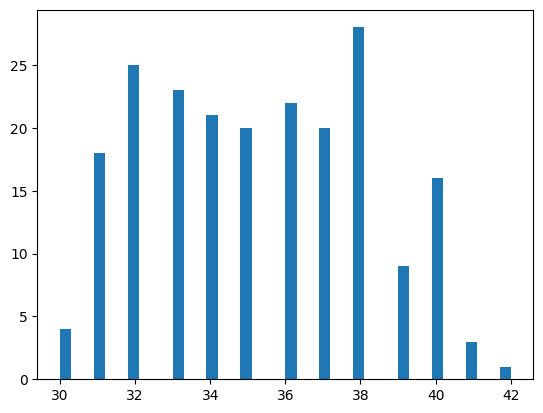

In [ ]:
print(sum(dfy.tokens.values))
plt.hist(dfy.tokens, bins= 40);


<a id="3"></a> <br>
# 3. Generacion de Embedding

##### para esta primera prueba utilizaremos de input 85977 tokens de entrada y de respuesta seran 250.

In [ ]:
# antes de correr cualquier modelo de la api de openai debemos asegurarnos que esta ya esta,
#completamente configurada en el ambiente.

#ahora
#dfy["embedding"] = dfy.mix.apply(lambda x: get_embedding(x, model=embedding_model))



In [ ]:
dfy.head(5)

,tim_day,seller_nickname,titulo,seller_reputation,stock,logistic_type,condition,is_refurbished,price,regular_price,...,category_id,category_name,Kmeans,AgC,products,Siglas_lt,Lt,mix,tokens,embedding
0,2024-08-01,7ef2f8612c,Cabecera Queen Size Dicasa Aries Gris,red,1,Otro,new,0,3699.0,NaN,...,FURNITURE,MUEBLES,3.0,0.0,11.0,Otro,Otro,Stock: 1; Refurbished: 0; Logistic: Otro; Cond...,34,"[-0.032292187213897705, 0.017587708309292793, ..."
1,2024-08-01,f47a79fba8,Reproduccion Medallas Americanas Antiguas,green,1,Otro,used,0,1364.58,NaN,...,OTHER,OTROS,3.0,0.0,14.0,Otro,Otro,Stock: 1; Refurbished: 0; Logistic: Otro; Cond...,31,"[-0.03797304257750511, 0.024722589179873466, -..."
2,2024-08-01,d632aaa54e,Alcohol Isopropílico 99.8% Puro 1 Litro Quimik...,green_gold,39,Otro,new,0,118.0,NaN,...,"IT PERIPHERALS, PARTS & ACCESSORIES",PERIFÉRICOS Y ACCESORIOS DE INFORMÁTICA,2.0,0.0,5.0,Otro,Otro,Stock: 39; Refurbished: 0; Logistic: Otro; Con...,39,"[-0.039741143584251404, 0.025698775425553322, ..."
3,2024-08-01,a9c03cf5a9,2 Ml En Decant De Desirtoxic De M. Micallef Pe...,green_gold,1,XD,new,0,235.0,NaN,...,FRAGRANCES & MAKE UP,FRAGANCIAS Y MAQUILLAJE,1.0,1.0,17.0,XD,Cross Docking,Stock: 1; Refurbished: 0; Logistic: Cross Dock...,36,"[-0.012618849985301495, 0.005941668525338173, ..."
4,2024-08-01,4e5692f432,1989 Toy Biz Super Heroes Wonder Woman Power A...,green,1,XD,used,0,1420.0,NaN,...,TOYS AND GAMES,JUGUETES Y JUEGOS,3.0,0.0,13.0,XD,Cross Docking,Stock: 1; Refurbished: 0; Logistic: Cross Dock...,36,"[-0.013756437227129936, 0.035540711134672165, ..."


In [ ]:
#ahora vemos nuestras lista los embedding desde 3-small de la muestra de nuestros datos.
print(dfy['embedding'].shape)
dfy['embedding']

(210,)


0      [-0.032292187213897705, 0.017587708309292793, ...
1      [-0.03797304257750511, 0.024722589179873466, -...
2      [-0.039741143584251404, 0.025698775425553322, ...
3      [-0.012618849985301495, 0.005941668525338173, ...
4      [-0.013756437227129936, 0.035540711134672165, ...
                             ...                        
205    [-0.02608417347073555, 0.022233540192246437, -...
206    [-0.041574642062187195, 0.031311675906181335, ...
207    [-0.03605155274271965, 0.047306548804044724, -...
208    [-0.0022978964261710644, 0.03379932418465614, ...
209    [-0.04414993152022362, 0.021153071895241737, -...
Name: embedding, Length: 210, dtype: object

<a id="4"></a> <br>
# 4. Exportacion del Embedding

In [ ]:
dfy.to_csv("data/data_embedding_270.csv")
